In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

from skyrim.models import FoundationModel
import datetime

In [3]:
# list all available models
FoundationModel.list_available_models()

['pangu', 'fcnv2_sm', 'graphcast', 'fcn', 'dlwp']

In [4]:
# initialize the pangu model
model = FoundationModel(model_name="pangu")

2024-04-20 21:37:04.759 | INFO     | skyrim.models:__init__:69 - Fetching pangu model package from e2mip://pangu


2024-04-20 21:37:36.513 | SUCCESS  | skyrim.models:__init__:74 - Loaded pangu model in 31.8 seconds


In [5]:
# lets predict the next state
first_state = model.predict_one_step(start_time=datetime.datetime(2018, 1, 1))
print(first_state.shape)

2024-04-20 21:37:46.716 | INFO     | skyrim.inference:run_basic_inference:20 - Fetching initial conditions from data source
/opt/conda/envs/earth2mip/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


(2, 1, 69, 721, 1440)


In [6]:
# lets predict the next 10 states
final_state, output_paths = model.rollout(
    start_time=datetime.datetime(2018, 1, 1), n_steps=10
)

2024-04-20 21:38:16.019 | INFO     | skyrim.inference:run_basic_inference:20 - Fetching initial conditions from data source
/opt/conda/envs/earth2mip/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
2024-04-20 21:38:17.964 | INFO     | skyrim.models:save_output:176 - Saving outputs to /root/skyrim/outputs/pangu/pangu__cds__20180101_00:00__20180101_06:00.nc
2024-04-20 21:38:18.745 | SUCCESS  | skyrim.models:save_output:184 - outputs saved to /root/skyrim/outputs/pangu/pangu__cds__20180101_00:00__20180101_06:00.nc
2024-04-20 21:38:18.747 | SUCCESS  | skyrim.models:rollout:152 - Rollout step 1/10 completed
2024-04-20 21:38:18.748 | INFO     | skyrim.inference:run_basic_inference:22 - Using provided initial conditions
/opt/conda/envs/earth2mip/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
2

In [7]:
import xarray as xr

first_state_loaded = xr.open_dataarray(output_paths[0])
print(first_state_loaded.shape)

(2, 1, 69, 721, 1440)


In [9]:
second_state = xr.open_dataarray(output_paths[1])
print(second_state.shape)
print(second_state.time.values)

(2, 1, 69, 721, 1440)
['2018-01-01T06:00:00.000000000' '2018-01-01T12:00:00.000000000']


In [10]:
second_state_cds = model.predict_one_step(start_time=datetime.datetime(2018, 1, 1, 6))
print(second_state_cds.shape)
print(second_state_cds.time.values)

2024-04-20 21:40:06.674 | INFO     | skyrim.inference:run_basic_inference:20 - Fetching initial conditions from data source
/opt/conda/envs/earth2mip/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


(2, 1, 69, 721, 1440)
['2018-01-01T06:00:00.000000000' '2018-01-01T12:00:00.000000000']


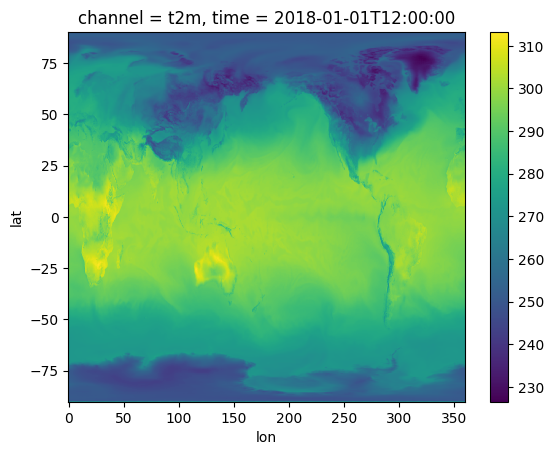

In [11]:
second_state.isel(time=1).sel(channel="t2m").squeeze().plot()

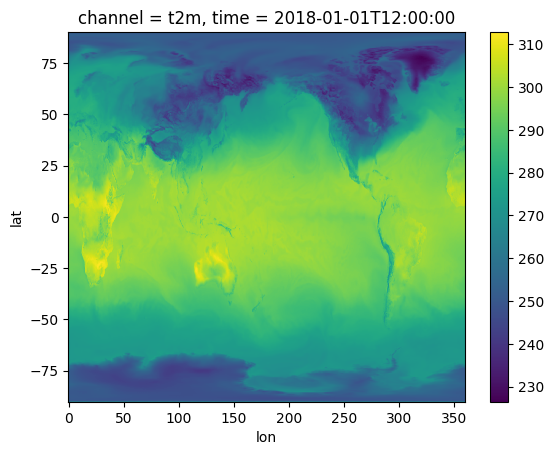

In [12]:
second_state_cds.isel(time=1).sel(channel="t2m").squeeze().plot()

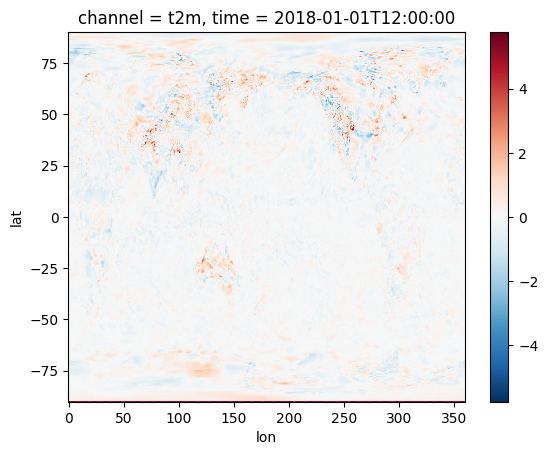

In [13]:
second_state_diff = second_state - second_state_cds
second_state_diff.isel(time=1).sel(channel="t2m").squeeze().plot()

In [19]:
def describe_t2m_diff(cds_da, model_da):
    diff = model_da - cds_da
    print(diff.isel(time=1).sel(channel="t2m").squeeze().max().item())
    print(diff.isel(time=1).sel(channel="t2m").squeeze().min().item())
    print(diff.isel(time=1).sel(channel="t2m").squeeze().mean().item())
    print(diff.isel(time=1).sel(channel="t2m").squeeze().std().item())

describe_t2m_diff(second_state_cds, second_state)

5.763519287109375
-4.4681854248046875
-0.009515568614006042
0.421856164932251


In [29]:
import pandas as pd

tenth_state = xr.open_dataarray(output_paths[-1])
# Convert the first datetime64 value to a datetime.datetime object
cds_start_time = pd.to_datetime(tenth_state.time.values[0]).to_pydatetime()
tenth_state_cds = model.predict_one_step(start_time=cds_start_time)

2024-04-20 21:50:05,480 INFO Welcome to the CDS
2024-04-20 21:50:05,482 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-04-20 21:50:05,511 INFO Welcome to the CDS
2024-04-20 21:50:05,513 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2024-04-20 21:50:05,650 INFO Request is queued
2024-04-20 21:50:06,770 INFO Request is running
2024-04-20 21:50:06,777 INFO Request is queued
2024-04-20 21:50:08,398 INFO Request is running
2024-04-20 21:50:10,771 INFO Request is queued
2024-04-20 21:50:14,278 INFO Request is completed
2024-04-20 21:50:14,280 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data6/adaptor.mars.internal-1713649811.1172776-11250-11-54766e27-fab1-451d-b0ef-943a4b857a99.grib to /root/.cache/earth2mip/cds/1788df7a97b270e3478e96cc700bc9fd3cd9d50008896b045145f00ada3271fa/reanalysis-era5-single-levels.grib.tmp (7.9M)
20